# Dataset

In [1]:
from google.colab import drive
drive.mount("/content/drive")

path_to_data = "/content/drive/MyDrive/HKUST/COMP4332_Project1/data"
!rm -f data
!ln -s "/content/drive/MyDrive/HKUST/COMP4332_Project1/data" data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [3]:
from torch import cuda
device = "cuda" if cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda'

In [4]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
pred_file = "data/valid_pred.csv"

df_train = pd.read_csv(train_file)
df_valid = pd.read_csv(valid_file)

df_train = df_train.sample(frac=1.0, random_state=0)

df_train.head()

,id,text,label
1469,ARM1PZMP947CR_20925,There are some very classic Gleason moves in t...,3
9642,ADWNWRH2CM8O1_22023,This looked pretty to give.\n\nWanted a stocki...,3
2107,A37AQ825XM4L27_14691,"Love the double feature, Remember to flip the ...",4
17031,A3EQ59IDF0S5E6_6347,I was so in love with the all of the characte...,5
9349,A3K3KFCBER9JBR_9597,Plenty good stuff in this one. Some flat spot...,4


<Axes: ylabel='count'>

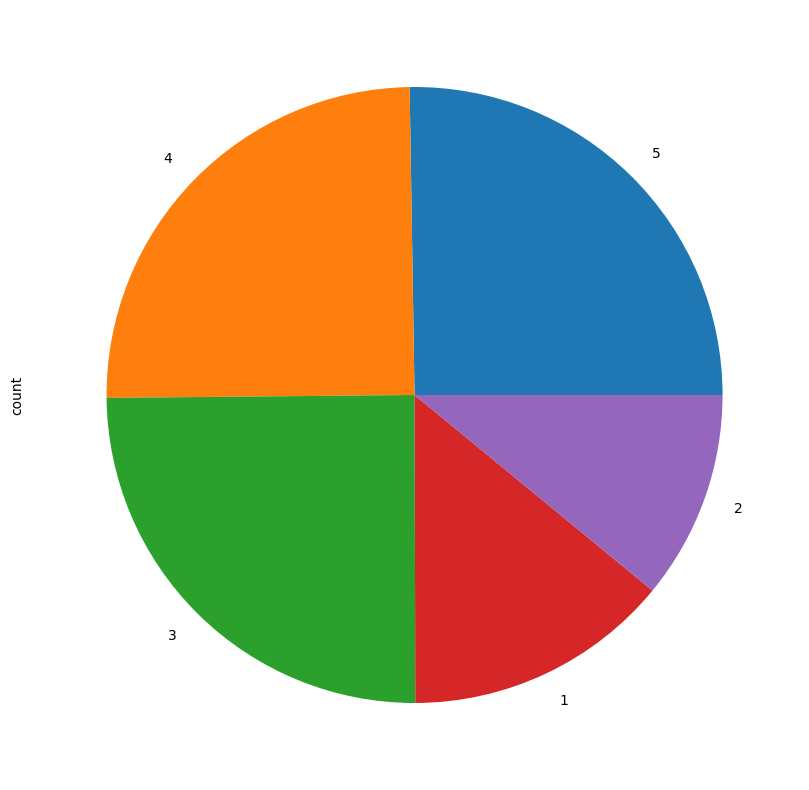

In [5]:
df_train.label.value_counts().plot(kind='pie', figsize=(10,10))

In [6]:
df_train["label"] = [y - 1 for y in df_train["label"]]
df_valid["label"] = [y - 1 for y in df_valid["label"]]

In [7]:
df_train.head()

,id,text,label
1469,ARM1PZMP947CR_20925,There are some very classic Gleason moves in t...,2
9642,ADWNWRH2CM8O1_22023,This looked pretty to give.\n\nWanted a stocki...,2
2107,A37AQ825XM4L27_14691,"Love the double feature, Remember to flip the ...",3
17031,A3EQ59IDF0S5E6_6347,I was so in love with the all of the characte...,4
9349,A3K3KFCBER9JBR_9597,Plenty good stuff in this one. Some flat spot...,3


In [8]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_ids, train_texts, train_labels = df_train["id"], df_train["text"], df_train["label"]
valid_ids, valid_texts, valid_labels = df_valid["id"], df_valid["text"], df_valid["label"]

In [12]:
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

In [13]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [14]:
from torch.utils.data import DataLoader

train_texts_list = train_texts.tolist()
train_labels_list = train_labels.tolist()
valid_texts_list = valid_texts.tolist()
valid_labels_list = valid_labels.tolist()

train_dataset = TextDataset(train_texts_list, train_labels_list, tokenizer, 50)
valid_dataset = TextDataset(valid_texts_list, valid_labels_list, tokenizer, 50)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [15]:
from transformers import AdamW
from tqdm import tqdm
import numpy as np

In [16]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    model.train()
    total_loss = 0
    total_train_accuracy = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to("cpu").numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Training Accuracy: {avg_train_accuracy}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1800/1800 [01:22<00:00, 21.80it/s]


Epoch 1, Training Loss: 1.1289737517717813, Training Accuracy: 0.5069444444444444


100%|██████████| 1800/1800 [01:23<00:00, 21.62it/s]


Epoch 2, Training Loss: 0.9050766093118323, Training Accuracy: 0.6170833333333333


100%|██████████| 1800/1800 [01:19<00:00, 22.55it/s]

Epoch 3, Training Loss: 0.6874466122438511, Training Accuracy: 0.7197222222222223


In [18]:
model.eval()
total_eval_accuracy = 0
total_eval_loss = 0

for batch in valid_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    loss = outputs.loss
    logits = outputs.logits

    total_eval_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to("cpu").numpy()
    total_eval_accuracy += flat_accuracy(logits, label_ids)

avg_val_accuracy = total_eval_accuracy / len(valid_loader)
avg_val_loss = total_eval_loss / len(valid_loader)
print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}")

Validation Loss: 1.0704565771818162, Validation Accuracy: 0.568


In [19]:
model_save_path = "data/model_state_dict.bin"
torch.save(model.state_dict(), model_save_path)